Skin Cancer Classification Final Project

In [7]:
# importing dataset
import kagglehub
import os
import pandas as pd
import shutil

# Download latest version
# path = kagglehub.dataset_download("jaiahuja/skin-cancer-detection")

dataset_path = kagglehub.dataset_download("jaiahuja/skin-cancer-detection")

# Move/copy to current working directory in Colab
!mkdir -p /content/SkinCancer
shutil.copytree(dataset_path, '/content/SkinCancer', dirs_exist_ok=True)

# Paths you can use for PyTorch ImageFolder
train_path = 'Train'
test_path = 'Test'

Using Colab cache for faster access to the 'skin-cancer-detection' dataset.


In [ ]:
# declaring global variables
BATCH_SIZE = 32
HEIGHT_IMG = 180
WIDTH_IMG = 180

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import os
import matplotlib.pyplot as plt
# import glob

transform = transforms.Compose([
    transforms.Resize((HEIGHT_IMG, WIDTH_IMG)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder("Train", transform=transform)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = datasets.ImageFolder("Test", transform=transform)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# images, labels = next(iter(train_loader))
# print(f'Image batch shape: {images.size()}')
# print(f'Label batch shape: {labels.size()}')





In [10]:

validation_size = int(0.2 * len(train_data))
training_size = len(train_data) - validation_size
train_dataset, val_dataset = random_split(train_data, [training_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [21]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)


        # fully connected layers
        self.fc1 = nn.Linear(30976, 128)
        self.fc2 = nn.Linear(128, 9)  # Assuming binary classification

    def forward(self, x):
        # x /= 255.0  # Normalize input to [0, 1]

        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)
        # remember to always zero out the gradient first. Don't want old values
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # tracking prog
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_accuracy = 100 * train_correct / total
    train_loss_epoch = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for image, labels in val_loader:
            image, labels = image.to(device), labels.to(device)
            # optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item()

    val_accuracy = 100 * val_correct / total_val
    val_loss_epoch = val_loss / len(val_loader)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.9330, Accuracy: 27.73%


  5%|▌         | 1/20 [00:08<02:40,  8.45s/it]

Validation Loss: 1.8408, Validation Accuracy: 32.44%
Epoch 2/20, Loss: 1.6469, Accuracy: 41.46%


 10%|█         | 2/20 [00:16<02:30,  8.36s/it]

Validation Loss: 1.4947, Validation Accuracy: 45.86%
Epoch 3/20, Loss: 1.4838, Accuracy: 47.27%


 15%|█▌        | 3/20 [00:25<02:24,  8.49s/it]

Validation Loss: 1.5062, Validation Accuracy: 46.09%
Epoch 4/20, Loss: 1.3549, Accuracy: 51.79%


 20%|██        | 4/20 [00:33<02:15,  8.48s/it]

Validation Loss: 1.3384, Validation Accuracy: 53.69%
Epoch 5/20, Loss: 1.2796, Accuracy: 55.02%


 25%|██▌       | 5/20 [00:42<02:06,  8.44s/it]

Validation Loss: 1.3013, Validation Accuracy: 55.26%
Epoch 6/20, Loss: 1.2773, Accuracy: 54.80%


 30%|███       | 6/20 [00:50<01:57,  8.41s/it]

Validation Loss: 1.3016, Validation Accuracy: 53.91%
Epoch 7/20, Loss: 1.1321, Accuracy: 60.44%


 35%|███▌      | 7/20 [00:59<01:49,  8.42s/it]

Validation Loss: 1.3009, Validation Accuracy: 53.69%
Epoch 8/20, Loss: 1.1733, Accuracy: 58.65%


 40%|████      | 8/20 [01:07<01:40,  8.39s/it]

Validation Loss: 1.3257, Validation Accuracy: 52.57%
Epoch 9/20, Loss: 1.0324, Accuracy: 63.34%


 45%|████▌     | 9/20 [01:15<01:32,  8.42s/it]

Validation Loss: 1.3334, Validation Accuracy: 54.81%
Epoch 10/20, Loss: 0.9755, Accuracy: 65.74%


 50%|█████     | 10/20 [01:24<01:23,  8.37s/it]

Validation Loss: 1.4194, Validation Accuracy: 53.69%
Epoch 11/20, Loss: 0.9593, Accuracy: 66.13%


 55%|█████▌    | 11/20 [01:32<01:16,  8.45s/it]

Validation Loss: 1.3202, Validation Accuracy: 54.14%
Epoch 12/20, Loss: 0.7753, Accuracy: 72.04%


 60%|██████    | 12/20 [01:41<01:07,  8.46s/it]

Validation Loss: 1.3789, Validation Accuracy: 54.14%
Epoch 13/20, Loss: 0.7015, Accuracy: 75.61%


 65%|██████▌   | 13/20 [01:49<00:58,  8.40s/it]

Validation Loss: 1.6694, Validation Accuracy: 51.45%
Epoch 14/20, Loss: 0.6409, Accuracy: 76.73%


 70%|███████   | 14/20 [01:57<00:50,  8.37s/it]

Validation Loss: 1.5478, Validation Accuracy: 53.69%
Epoch 15/20, Loss: 0.5820, Accuracy: 78.85%


 75%|███████▌  | 15/20 [02:05<00:41,  8.30s/it]

Validation Loss: 1.8731, Validation Accuracy: 50.78%
Epoch 16/20, Loss: 0.5965, Accuracy: 78.07%


 80%|████████  | 16/20 [02:14<00:33,  8.31s/it]

Validation Loss: 1.8493, Validation Accuracy: 49.89%
Epoch 17/20, Loss: 0.4587, Accuracy: 82.31%


 85%|████████▌ | 17/20 [02:22<00:24,  8.29s/it]

Validation Loss: 1.8089, Validation Accuracy: 51.01%
Epoch 18/20, Loss: 0.4052, Accuracy: 83.76%


 90%|█████████ | 18/20 [02:31<00:16,  8.39s/it]

Validation Loss: 1.9399, Validation Accuracy: 51.68%
Epoch 19/20, Loss: 0.4558, Accuracy: 83.26%


 95%|█████████▌| 19/20 [02:39<00:08,  8.44s/it]

Validation Loss: 1.9378, Validation Accuracy: 50.78%
Epoch 20/20, Loss: 0.3361, Accuracy: 86.94%


100%|██████████| 20/20 [02:48<00:00,  8.41s/it]

Validation Loss: 2.1394, Validation Accuracy: 53.02%


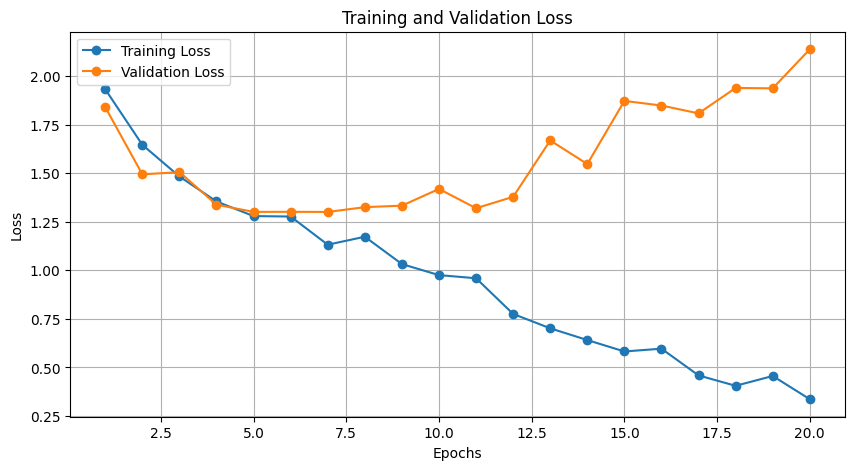

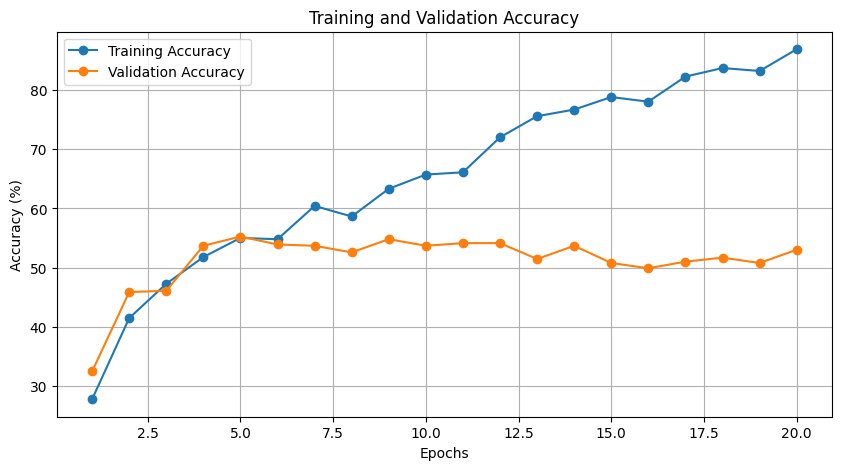

In [23]:
import matplotlib.pyplot as plt


epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()